In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Подготовка данных

In [2]:
df = pd.read_csv('Data_set.csv')

In [3]:
df.head()

,Unnamed: 0,MONTH,DAY,M,BALL,SPEED_RES_PAS,SPEED_RES_FRE,SPEED_RES_EMPTY,SPEED_NORM_PAS,SPEED_NORM_FRE,...,O_4,O_T,delta_OTS_2,delta_OTS_3,delta_OTS_4,delta_O_1,delta_O_2,delta_O_3,delta_O_4,delta_O_T
0,5,1,19,1,10,1000,1000,1000,60,50,...,0,1,1,0,0,0,1,0,0,1
1,8,1,23,1,10,1000,1000,1000,140,90,...,0,1,-1,0,0,0,-1,0,0,-1
2,11,1,23,1,10,1000,1000,1000,160,90,...,0,0,-2,0,0,0,-2,0,0,-2
3,13,1,23,1,10,1000,1000,1000,160,90,...,0,0,0,0,0,0,0,0,0,0
4,15,1,23,1,10,1000,1000,1000,160,90,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.isnull().values.any()

False

In [5]:
np_df = df.drop(['TARGET', 'M', 'Unnamed: 0'], axis = 1).values
np_labels = np.array(df.TARGET)

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(np_df, np_labels, test_size=0.2, random_state=10)

blade = 92347 # Последние полгода

# Разобьем на трейн-тест выборку
X_train, X_test, y_train, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:]

In [7]:
X_train = torch.FloatTensor(X_train) 
y_train = torch.FloatTensor(y_train) 

X_test = torch.FloatTensor(X_test) 
y_test = torch.FloatTensor(y_test)

In [8]:
X_train.shape, 

(torch.Size([92347, 143]),)

In [9]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1)

## Напишем автоэнкодер

**Идея**: Сетка состоит из двух блоков - encoder & decoder. 

Encoder для каждой строчки из нашего датасета получает какое-то скрытое (латентное) представление.

Decoder пытается по этому латентному вектору предсказать *исходный* вектор. Т.е. по сути мы учим

нашу сеть предсказывать ее же вход. Затем, мы прогоняем наш train и получаем для каждой строки ее

скрытое представление - латентный вектор (функция get_latent_vector), который мы уже сравниваем с

латентным вектором test с помощью косинусного расстояния. Т.е. ключевая идея в том, что в латентном

пространстве векторы соответсвующие TARGET=0 и TARGET=1 находятся в разных "местах".
отличать их друг от друга

**Для чего это нужно.**

Мне показалось это хорошей идеей по следующей причине.

Т.к. у нас есть изначально неверные данные, то сетка уже изначально учится на ошибках. Тут же

мы учим сеть предсказывать то, что ей подали на вход, поэтому на этапе обучения пропуски/ошибки 

никак не влияют.

In [10]:
dim_code=16

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=143, out_features=64),
            nn.SiLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.SiLU(),
            nn.Linear(in_features=32, out_features=dim_code),
            nn.SiLU()
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=32),
            nn.SiLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.SiLU(),
            nn.Linear(in_features=64, out_features=143),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent_code = self.encoder(x.float())
        reconstruction = self.decoder(latent_code)
        return reconstruction
    
    def get_latent_vector(self, x):
        latent_code = self.encoder(x.float())
        return latent_code

    def sample(self, z):
        generated = self.decoder(z)
        return generated

In [12]:
def train(model, optimizer, criterion, train_loader, val_loader, n_epochs=20):
    train_losses = []
    val_losses = []

    for epoch in trange(n_epochs):
        model.train()
        train_losses_per_epoch = []
        for X_batch in train_loader:
#             print("\n X_batch.shape = ", X_batch.shape)
            optimizer.zero_grad()
            reconstruction = model(X_batch.to(device))
#             print("\n reconstruction =", reconstruction)
            loss = criterion(reconstruction, X_batch.to(device))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
            break
        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch in val_loader:
                reconstruction = model(X_batch.to(device))
                loss = criterion(X_batch.to(device).float(), reconstruction)
                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return train_losses, val_losses

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [14]:
criterion = nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

In [15]:
train_losses, val_losses = train(autoencoder, optimizer, criterion, train_loader, test_loader, n_epochs=40)

100%|██████████| 40/40 [01:53<00:00,  2.85s/it]


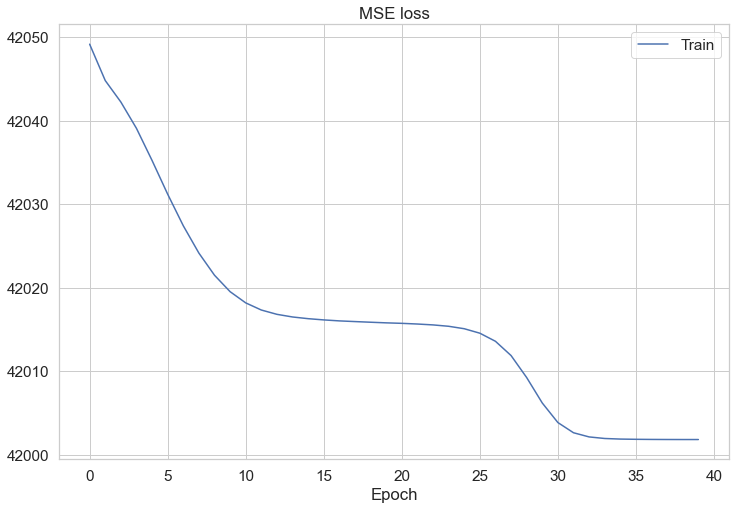

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
# plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()

plt.show()

1. Loss function (sum -> mean)
2. mu, log_sigma

In [17]:
test_loader = torch.utils.data.DataLoader(X_test, batch_size=128)
y_test_loader = torch.utils.data.DataLoader(y_test, batch_size=128)

test_loader = iter(test_loader)
y_test_loader = iter(y_test_loader)

X_batch, y_batch = next(zip(test_loader, y_test_loader))

In [18]:
X_batch.shape, y_batch.shape

(torch.Size([128, 143]), torch.Size([128]))

In [19]:
y_batch = y_batch.int()
y_batch.dtype, type(y_batch)

(torch.int32, torch.Tensor)

In [20]:
model = autoencoder
latent_vector_list = model.get_latent_vector(X_batch.to(device))
labels = y_batch.reshape(-1, 1)
for X_batch, y_batch in zip(test_loader, y_test_loader):
    batch_sample = model.get_latent_vector(X_batch.to(device))
    latent_vector_list = torch.vstack((latent_vector_list, batch_sample))
    labels = torch.vstack((labels, y_batch.reshape(-1, 1)))

In [21]:
latent_vector_list.shape, labels.shape

(torch.Size([15250, 16]), torch.Size([15250, 1]))

In [22]:
latent_vector_list = latent_vector_list.detach().cpu()
labels = labels.detach().cpu()

In [23]:
labels = labels.int()
labels.dtype

torch.int32

In [24]:
labels.unique()

tensor([0, 1], dtype=torch.int32)

In [25]:
# X_embedded = TSNE(n_components=2).fit_transform(latent_vector_list)
# X_embedded.shape

In [26]:
# plt.figure(figsize=[20, 10])
# graph = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels.reshape(-1), cmap='summer')
# plt.colorbar(graph)
# plt.show()

Посчитаем средний вектор (mu) латентного пространства для объектов у которых TARGET=1 и отдельно для TARGET=0.

In [27]:
# X_train, X_test, y_train, y_test = train_test_split(np_df, np_labels, test_size=0.2, random_state=10)

blade = 92347 # Последние полгода

# Разобьем на трейн-тест выборку
X_train, X_test, y_train, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:]

In [28]:
X_zeros = []
X_ones = []

for x, y in zip(X_train, y_train):
    if y == 0:
        X_zeros.append(x)
    else:
        X_ones.append(x)

In [29]:
X_zeros = torch.utils.data.DataLoader(torch.FloatTensor(X_zeros), batch_size=32)
X_ones = torch.utils.data.DataLoader(torch.FloatTensor(X_ones), batch_size=32)

In [30]:
X_zeros = iter(X_zeros)
X_ones = iter(X_ones)

In [31]:
X_zeros_batch = next(X_zeros)
X_ones_batch = next(X_ones)

In [32]:
model = autoencoder

In [33]:
latent_zeros_list = model.get_latent_vector(X_zeros_batch)
latent_ones_list = model.get_latent_vector(X_ones_batch)

In [34]:
for X_zeros_batch in X_zeros:
    zeros_sample = model.get_latent_vector(X_zeros_batch)
    latent_zeros_list = torch.vstack((latent_zeros_list, zeros_sample))
    
for X_ones_batch in X_ones:
    ones_sample = model.get_latent_vector(X_ones_batch)
    latent_ones_list = torch.vstack((latent_ones_list, ones_sample))

In [35]:
latent_zeros_list.shape

torch.Size([78796, 16])

In [36]:
latent_ones_list.shape

torch.Size([13551, 16])

In [37]:
mean_zeros = latent_zeros_list.mean(dim=0)
mean_ones = latent_ones_list.mean(dim=0)
mean_zeros, mean_ones # по два нуля

(tensor([ 7.4220e+01,  8.2660e+01,  9.6124e+01, -1.3205e-05,  1.5969e+00,
         -8.4742e-10, -1.1743e-04, -3.2718e-07,  4.2765e+01, -5.1407e-10,
          2.6653e+01, -2.1836e-12, -8.4435e-07,  1.1270e+02, -5.9054e-05,
          1.5618e-01], grad_fn=<MeanBackward1>),
 tensor([ 6.9811e+01,  7.9976e+01,  9.2517e+01, -1.9526e-04,  1.6097e+00,
         -1.0391e-07, -1.5607e-04, -5.8034e-06,  4.2510e+01, -3.6711e-08,
          2.5702e+01, -4.9125e-09, -1.2639e-05,  1.0697e+02, -2.7299e-04,
          6.4371e-01], grad_fn=<MeanBackward1>))

In [38]:
from scipy import spatial

In [39]:
SMOOTH = 1e-6

In [40]:
def cosine(a, b):
    num = (a * b).sum()
    den = (a**2).sum().sqrt() * (b**2).sum().sqrt()
    return num / (den + SMOOTH)

In [41]:
X_test.shape

(15250, 143)

In [42]:
test_loader = torch.utils.data.DataLoader(torch.FloatTensor(X_test), batch_size=15250)
y_test_loader = torch.utils.data.DataLoader(torch.FloatTensor(y_test), batch_size=15250)

In [43]:
def cos_dist(X_batch, y):
    X_batch = iter(X_batch)
    x = next(X_batch)
    res = cosine(x, y)
    
    for x in X_batch:
        res = torch.vstack((res, cosine(x, y)))
        
    return res

In [44]:
for X_batch, y_batch in zip(test_loader, y_test_loader):
    output = model.get_latent_vector(X_batch)
#     print(output)
    preds_zeros = cos_dist(output.detach(), mean_zeros.detach())
    preds_ones = cos_dist(output.detach(), mean_ones.detach())
    preds = torch.hstack((preds_ones, preds_zeros)) / (preds_zeros + preds_ones)
    break

In [45]:
preds = preds.detach().cpu().numpy()

In [46]:
preds[:,0].shape

(15250,)

In [47]:
test_auc = roc_auc_score(y_batch, preds[:,0])

In [48]:
fpr, tpr, th = roc_curve(y_batch, preds[:,0])
gmeans = np.sqrt(tpr * (1-fpr))
ix = argmax(gmeans)

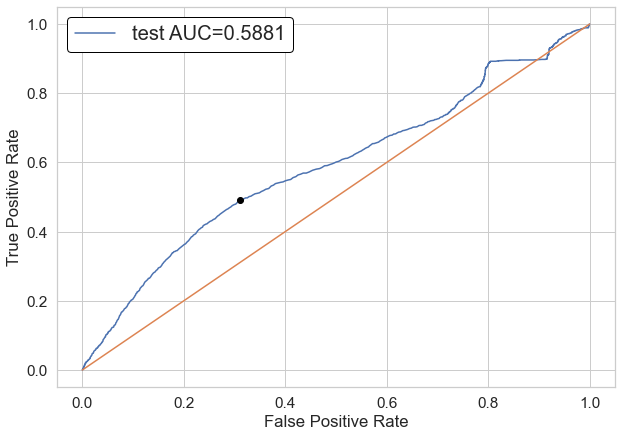

In [49]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_batch, preds[:,0])[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

1. F.mse_loss 40epoch 0.7765
2. F.mse_loss 60epoch 0.7849

3. nn.MSE 40epoch 0.7859
4. nn.MSE 60epoch 0.8002

5. nn.MSE 40epoch 0.8030 (silu)
6. nn.MSE 60epoch 0.8014 (silu)

In [50]:
from scipy import spatial
import numpy as np

a = torch.randn(1, 2)
b = torch.randn(4, 2) # different row number, for the fun

# Given that cos_sim(u, v) = dot(u, v) / (norm(u) * norm(v))
#                          = dot(u / norm(u), v / norm(v))
# We fist normalize the rows, before computing their dot products via transposition:
a_norm = a / a.norm(dim=1)[:, None]
b_norm = b / b.norm(dim=1)[:, None]
res = torch.mm(a_norm, b_norm.transpose(0,1))
print(res)
#  0.9978 -0.9986 -0.9985
# -0.8629  0.9172  0.9172


tensor([[-0.1271, -0.7117,  0.6435,  0.6977]])


In [51]:
a, b

(tensor([[1.0046, 0.8370]]),
 tensor([[-1.1800,  1.0965],
         [-0.2117, -2.1702],
         [ 1.5296, -0.2738],
         [ 0.0829,  1.0676]]))

In [52]:
a_norm, a / a.norm(dim=1)

(tensor([[0.7683, 0.6401]]), tensor([[0.7683, 0.6401]]))

In [53]:
for X_batch, y_batch in zip(test_loader, y_test_loader):
    output = model.get_latent_vector(X_batch)
    print(output.shape)
    preds_zeros = cos_dist(output.detach(), mean_zeros.detach())
    preds_ones = cos_dist(output.detach(), mean_ones.detach())
    preds = torch.hstack((preds_ones, preds_zeros)) / (preds_zeros + preds_ones)
    break

torch.Size([15250, 16])
